<a href="https://colab.research.google.com/github/griselbarrera2025/-ITAI2373-NewsBot-Midterm-/blob/main/newsbot_final_MIDTERM_GRISEL_BARRERA__2373.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# NewsBot Intelligence System

This notebook implements an end‑to‑end **NewsBot Intelligence System** for the mid‑term project. It integrates multiple NLP techniques to preprocess, analyze and extract insights from a news dataset. The system covers text cleaning, TF‑IDF analysis, part‑of‑speech and syntax analysis, sentiment and emotion analysis, multi‑class classification, and named‑entity recognition.

**Dataset**: BBC News Classification dataset (≈2,225 articles, five categories). To use a different dataset, update the loading section accordingly.



## Module 1: Real‑World NLP Application Context

In today’s digital landscape, news organizations, investors, and social‑media platforms need tools to monitor and interpret the massive stream of news articles published every day. **News intelligence systems** automatically categorize articles, extract entities (people, companies, places), analyze sentiment, and surface relevant insights.  

For this project, our system will serve two main user groups:

- **Media analysts and journalists** who need to quickly organize and summarize large volumes of articles by topic, discover emerging trends, and identify key entities.  
- **Business and finance professionals** who monitor news for company mentions, market sentiment, and competitive intelligence.

The value proposition of our NewsBot system is to reduce manual effort in sorting and interpreting news, enabling faster decision making and more informed analysis.


In [ ]:
# Install required libraries (uncomment in Colab)
# !pip install -q spacy pandas scikit-learn matplotlib seaborn nltk

# Download spaCy English model (small)
# !python -m spacy download en_core_web_sm

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True


## Imports

Load required Python libraries.


In [38]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag, ne_chunk, word_tokenize

import spacy
nlp = spacy.load('en_core_web_sm')

# Ensure NLTK data is available. If running in Colab, download using nltk.download() as shown in the installation cell.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()



## Load the dataset

Upload the dataset to your Colab environment. If using the BBC News dataset, download it via Kaggle or upload manually. Adjust the file path as needed.


In [40]:
# Path to the CSV file (update this to your file location)
dataset_path = '/content/bbc_news_dataset GOOGLE COLLAB #1.csv'

# Load dataset
df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...



## Explore and clean the dataset

Check for missing values and basic statistics. Rename columns to `content` and `category` for consistency.


category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


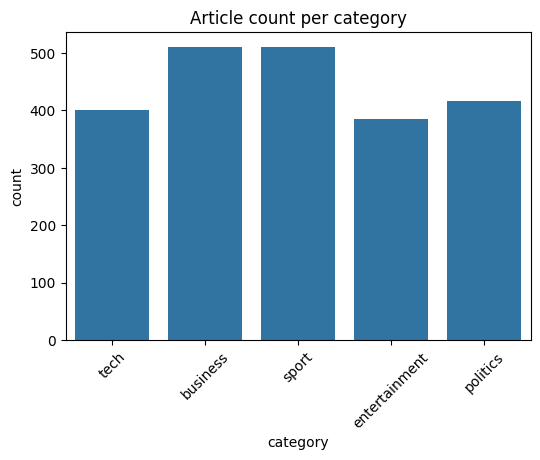

In [41]:
# Rename columns if needed
if 'text' in df.columns:
    df = df.rename(columns={'text': 'content'})
if 'label' in df.columns:
    df = df.rename(columns={'label': 'category'})

# Drop missing values
df = df.dropna(subset=['content', 'category'])

# Display category distribution
print(df['category'].value_counts())

# Visualize distribution
plt.figure(figsize=(6,4))
sns.countplot(x='category', data=df)
plt.title('Article count per category')
plt.xticks(rotation=45)
plt.show()



## Text preprocessing

Define a function to clean each document: lowercase conversion, removal of non‑alphabetic characters, tokenization, stop‑word removal, and lemmatization.


In [42]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    clean_tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return ' '.join(clean_tokens)

# Apply preprocessing (this may take a few minutes)
df['clean_content'] = df['content'].apply(preprocess_text)

df[['content', 'clean_content']].head()


,content,clean_content
0,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...



## TF‑IDF feature extraction and classification

Split the data into training and test sets, convert text to TF‑IDF features, and train a Logistic Regression classifier. Evaluate performance and display a confusion matrix.


Accuracy: 0.9797752808988764
               precision    recall  f1-score   support

     business       0.98      0.97      0.98       102
entertainment       0.96      1.00      0.98        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.97      0.96      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



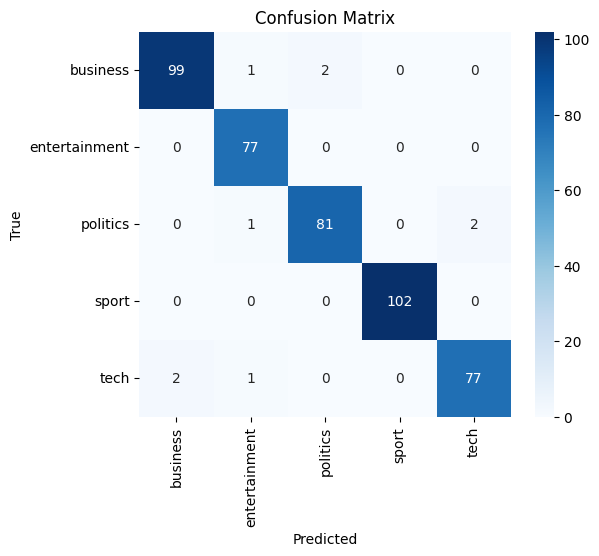

In [43]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



## Part‑of‑speech (POS) tagging and analysis

Use spaCy to tag part of speech for each token in a sample of articles. Calculate the distribution of POS tags across categories.


In [44]:
# Sample a subset for POS analysis (use a smaller sample to speed up)
pos_sample = df.sample(n=200, random_state=1)

# Function to get POS tag counts
def get_pos_counts(doc):
    doc_spacy = nlp(doc)
    pos_counts = {}
    for token in doc_spacy:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    return pos_counts

# Calculate POS counts per category
pos_distribution = {}
for category, group in pos_sample.groupby('category'):
    counts_list = group['content'].apply(get_pos_counts)
    # Sum counts across all documents in the category
    total_counts = {}
    for counts in counts_list:
        for tag, count in counts.items():
            total_counts[tag] = total_counts.get(tag, 0) + count
    pos_distribution[category] = total_counts

# Display POS distribution for each category
import pandas as pd
pos_df = pd.DataFrame(pos_distribution).fillna(0).astype(int)
pos_df


,business,entertainment,politics,sport,tech
NOUN,4431,2346,3383,3156,4640
VERB,2118,1090,1973,2116,2407
DET,1518,858,1459,1466,1570
ADJ,1398,705,1076,1103,1487
ADP,2146,1066,1612,1752,2060
PROPN,1461,1065,1244,1639,879
AUX,945,455,960,878,1121
PRON,695,519,939,1294,1012
SYM,128,13,25,109,46
NUM,702,250,260,518,432



## Sentiment analysis

Apply NLTK’s VADER sentiment analyzer to each article and analyze sentiment scores across categories.


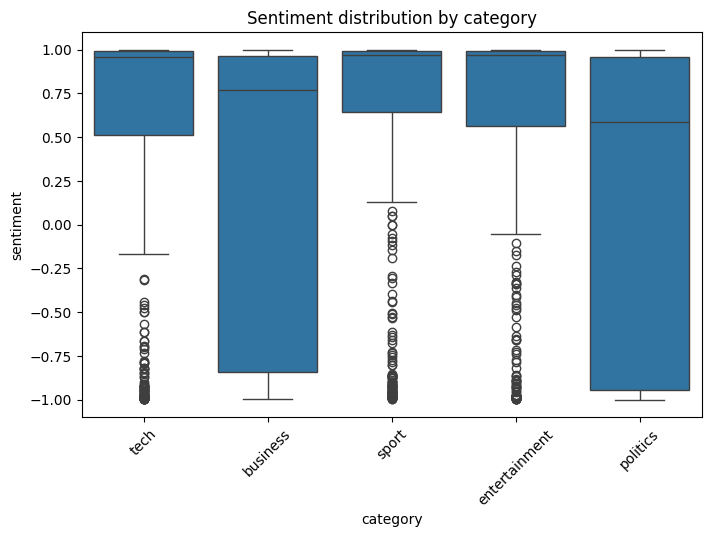

In [45]:
# Compute sentiment scores
df['sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot sentiment distribution by category
plt.figure(figsize=(8,5))
sns.boxplot(x='category', y='sentiment', data=df)
plt.title('Sentiment distribution by category')
plt.xticks(rotation=45)
plt.show()



## Named‑entity recognition (NER)

Use spaCy to extract named entities (PERSON, ORG, GPE, DATE, MONEY) from a subset of articles. Aggregate entity counts by category.


In [46]:
# Sample a subset for NER (limit to 200 articles to control runtime)
ner_sample = df.sample(n=200, random_state=2)

# Function to extract selected entity types
def extract_entities(doc):
    doc_spacy = nlp(doc)
    entities = []
    for ent in doc_spacy.ents:
        if ent.label_ in {'PERSON', 'ORG', 'GPE', 'DATE', 'MONEY'}:
            entities.append((ent.text, ent.label_))
    return entities

# Build entity frequency dictionary
entity_freq = {}
for category, group in ner_sample.groupby('category'):
    entities_list = group['content'].apply(extract_entities)
    freq = {}
    for ents in entities_list:
        for text, label in ents:
            key = f"{label}: {text}"
            freq[key] = freq.get(key, 0) + 1
    entity_freq[category] = freq

# Convert to DataFrame and display top entities per category
entity_df = pd.DataFrame(entity_freq).fillna(0).astype(int)
# Show only top 10 entities for brevity
entity_df.head(10)


,business,entertainment,politics,sport,tech
DATE: annual,15,0,2,1,0
GPE: uk,5,7,18,0,15
MONEY: 775,1,0,0,0,0
DATE: 2008,2,0,0,0,1
MONEY: 1.5,1,0,0,0,0
GPE: us,49,15,9,7,19
MONEY: $1.5m,1,0,0,0,0
MONEY: £799 000,1,0,0,0,0
ORG: monsanto,4,0,0,0,0
DATE: two years ago,1,0,0,1,0



## Conclusion and next steps

This notebook outlines a complete workflow for building a NewsBot Intelligence System, integrating text preprocessing, TF‑IDF analysis, POS and syntax analysis, sentiment analysis, multi‑class classification, and named‑entity recognition.

For your project deliverables, consider adding:

- Additional visualizations (e.g., word clouds, POS distribution charts)
- Hyperparameter tuning for the classifier
- Error analysis to understand misclassifications
- A user‑friendly interface (e.g., Streamlit or Gradio) for the optional bonus points
- A reflective journal summarizing your team’s experience and insights



### Category‑specific TF‑IDF analysis

To understand which terms are most characteristic for each news category, we can compute the sum of TF‑IDF scores per term within each category and then list the top terms. This helps identify words that are particularly important for distinguishing categories.


In [48]:
# Compute TF‑IDF matrix for all documents
full_tfidf = vectorizer.fit_transform(df['clean_content'])

# Map category labels to row indices
category_indices = {cat: df[df['category'] == cat].index for cat in df['category'].unique()}

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Compute top terms per category
top_terms = {}
for cat, indices in category_indices.items():
    # Sum TF‑IDF scores across rows in this category
    cat_tfidf_sum = full_tfidf[indices].sum(axis=0)
    cat_tfidf_array = cat_tfidf_sum.A1  # flatten
    # Get indices of top 10 terms
    top_idx = cat_tfidf_array.argsort()[-10:][::-1]
    top_terms[cat] = [(feature_names[i], cat_tfidf_array[i]) for i in top_idx]

# Display top terms
for cat, terms in top_terms.items():
    print(f"""
Top terms for {cat}:""")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")


Top terms for tech:
  mobile: 19.7561
  game: 17.4501
  people: 17.4107
  phone: 17.1162
  technology: 16.6059
  said: 16.3917
  user: 14.8205
  computer: 13.9448
  software: 13.2295
  service: 13.1107

Top terms for business:
  bn: 27.3802
  said: 24.6624
  company: 19.6321
  firm: 18.3883
  bank: 18.3022
  market: 17.8154
  year: 17.5160
  growth: 17.2750
  economy: 16.9927
  share: 15.9796

Top terms for sport:
  game: 22.0964
  england: 18.1953
  player: 17.3869
  win: 17.1508
  match: 16.4403
  said: 15.8069
  cup: 14.7266
  team: 14.5350
  final: 14.1447
  champion: 13.9609

Top terms for entertainment:
  film: 39.4564
  award: 21.7736
  best: 17.9934
  show: 15.2195
  star: 15.0707
  music: 13.5702
  band: 12.8857
  said: 12.8786
  year: 12.6636
  oscar: 12.1514

Top terms for politics:
  mr: 36.5997
  said: 27.4557
  labour: 26.7856
  election: 25.0976
  party: 23.3875
  blair: 22.5217
  tory: 19.9178
  government: 19.1786
  would: 18.2632
  minister: 17.4172



### Multi‑algorithm classification comparison

To evaluate different models, we will train several algorithms and compare their performance. Here we test Logistic Regression (already used), Multinomial Naïve Bayes, and Linear Support Vector Classifier (SVC).



Logistic Regression accuracy: 0.9798
               precision    recall  f1-score   support

     business       0.98      0.97      0.98       102
entertainment       0.96      1.00      0.98        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.97      0.96      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445


Multinomial NB accuracy: 0.9865
               precision    recall  f1-score   support

     business       0.99      0.96      0.98       102
entertainment       0.99      0.99      0.99        77
     politics       0.97      1.00      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.99      0.99      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99

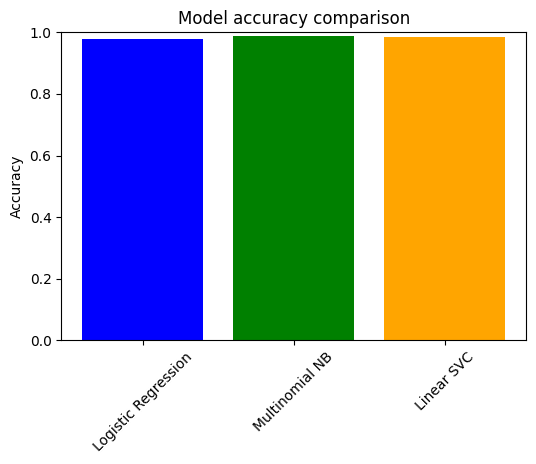

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'Linear SVC': LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"""
{name} accuracy: {acc:.4f}""")
    print(classification_report(y_test, preds))

# Plot comparison
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['blue','green','orange'])
plt.ylim(0,1)
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


### Syntax parsing and dependency analysis

Dependency parsing reveals grammatical relationships between words in a sentence. Using spaCy, we can extract dependency labels and identify common patterns across categories. Below, we parse a small sample of sentences and compute the frequency of dependency labels in each category.


In [53]:

# Sample subset for syntax analysis
syntax_sample = df.sample(n=200, random_state=3)

# Function to count dependency labels in a text
def get_dependency_counts(doc):
    parsed = nlp(doc)
    counts = {}
    for token in parsed:
        dep = token.dep_
        counts[dep] = counts.get(dep, 0) + 1
    return counts

# Aggregate dependency counts per category
dep_distribution = {}
for cat, group in syntax_sample.groupby('category'):
    all_counts = {}
    for text in group['content']:
        dep_counts = get_dependency_counts(text)
        for dep, count in dep_counts.items():
            all_counts[dep] = all_counts.get(dep, 0) + count
    dep_distribution[cat] = all_counts

# Convert to DataFrame and view top dependencies
dep_df = pd.DataFrame(dep_distribution).fillna(0).astype(int)
# Show top 10 dependencies by total frequency
dep_df['total'] = dep_df.sum(axis=1)
dep_df_sorted = dep_df.sort_values('total', ascending=False)
dep_df_sorted.head(10)


,business,entertainment,politics,sport,tech,total
prep,1794,1092,2067,1559,2623,9135
pobj,1742,1081,1941,1413,2535,8712
det,1361,961,1941,1362,2220,7845
nsubj,1192,784,1984,1426,2150,7536
compound,1265,1043,1518,1259,1757,6842
punct,1026,713,1312,1239,1646,5936
dep,1024,764,1443,1053,1620,5904
amod,1161,679,1353,891,1766,5850
dobj,738,477,1181,866,1339,4601
aux,716,426,1260,775,1295,4472


In [55]:
# Save the DataFrame to a CSV file
output_filename = 'bbc_news_dataset_output.csv'
df.to_csv(output_filename, index=False)

print(f"Dataset saved to {output_filename}")

Dataset saved to bbc_news_dataset_output.csv


In [56]:
# Save the DataFrame to a CSV file
output_filename = 'bbc_news_dataset_output.csv'
df.to_csv(output_filename, index=False)

print(f"Dataset saved to {output_filename}")

Dataset saved to bbc_news_dataset_output.csv


In [57]:
# Sample 1000 articles from the DataFrame
sampled_df = df.sample(n=1000, random_state=42)

print(f"Sampled DataFrame shape: {sampled_df.shape}")
display(sampled_df.head())

Sampled DataFrame shape: (1000, 4)


,category,content,clean_content,sentiment
414,politics,brown and blair face new rift claims for the u...,brown blair face new rift claim umpteenth time...,-0.9631
420,business,small firms hit by rising costs rising fuel ...,small firm hit rising cost rising fuel materia...,0.9612
1644,entertainment,spirit awards hail sideways the comedy sideway...,spirit award hail sideways comedy sideways dom...,0.9989
416,tech,microsoft releases patches microsoft has warne...,microsoft release patch microsoft warned pc us...,-0.9524
1232,sport,arsenal through on penalties arsenal win 4-2 o...,arsenal penalty arsenal win penalty spanish go...,0.9898


In [58]:
# Sample a subset for POS analysis (use a smaller sample to speed up)
pos_sample = df.sample(n=200, random_state=1)

# Function to get POS tag counts
def get_pos_counts(doc):
    doc_spacy = nlp(doc)
    pos_counts = {}
    for token in doc_spacy:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    return pos_counts

# Calculate POS counts per category
pos_distribution = {}
for category, group in pos_sample.groupby('category'):
    counts_list = group['content'].apply(get_pos_counts)
    # Sum counts across all documents in the category
    total_counts = {}
    for counts in counts_list:
        for tag, count in counts.items():
            total_counts[tag] = total_counts.get(tag, 0) + count
    pos_distribution[category] = total_counts

# Display POS distribution for each category
import pandas as pd
pos_df = pd.DataFrame(pos_distribution).fillna(0).astype(int)
pos_df

,business,entertainment,politics,sport,tech
NOUN,4431,2346,3383,3156,4640
VERB,2118,1090,1973,2116,2407
DET,1518,858,1459,1466,1570
ADJ,1398,705,1076,1103,1487
ADP,2146,1066,1612,1752,2060
PROPN,1461,1065,1244,1639,879
AUX,945,455,960,878,1121
PRON,695,519,939,1294,1012
SYM,128,13,25,109,46
NUM,702,250,260,518,432


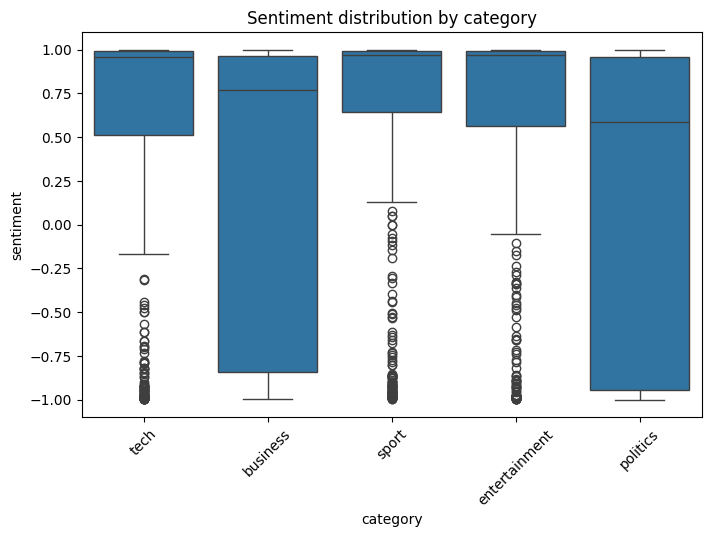

In [59]:
# Compute sentiment scores
df['sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot sentiment distribution by category
plt.figure(figsize=(8,5))
sns.boxplot(x='category', y='sentiment', data=df)
plt.title('Sentiment distribution by category')
plt.xticks(rotation=45)
plt.show()

In [60]:
# Sample a subset for NER (limit to 200 articles to control runtime)
ner_sample = df.sample(n=200, random_state=2)

# Function to extract selected entity types
def extract_entities(doc):
    doc_spacy = nlp(doc)
    entities = []
    for ent in doc_spacy.ents:
        if ent.label_ in {'PERSON', 'ORG', 'GPE', 'DATE', 'MONEY'}:
            entities.append((ent.text, ent.label_))
    return entities

# Build entity frequency dictionary
entity_freq = {}
for category, group in ner_sample.groupby('category'):
    entities_list = group['content'].apply(extract_entities)
    freq = {}
    for ents in entities_list:
        for text, label in ents:
            key = f"{label}: {text}"
            freq[key] = freq.get(key, 0) + 1
    entity_freq[category] = freq

# Convert to DataFrame and display top entities per category
entity_df = pd.DataFrame(entity_freq).fillna(0).astype(int)
# Show only top 10 entities for brevity
entity_df.head(10)

,business,entertainment,politics,sport,tech
DATE: annual,15,0,2,1,0
GPE: uk,5,7,18,0,15
MONEY: 775,1,0,0,0,0
DATE: 2008,2,0,0,0,1
MONEY: 1.5,1,0,0,0,0
GPE: us,49,15,9,7,19
MONEY: $1.5m,1,0,0,0,0
MONEY: £799 000,1,0,0,0,0
ORG: monsanto,4,0,0,0,0
DATE: two years ago,1,0,0,1,0


In [ ]:
# Path to the CSV file (update this to your file location)
dataset_path = '/content/bbc_news_dataset GOOGLE COLLAB #1.csv'

# Load dataset
df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
!ls /content/

 4787.f5129f48620a03126642.css
'BBC News Classification _ Kaggle_TEST.CSV'
'bbc_news_dataset GOOGLE COLLAB #1.csv'
 sample_data


category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


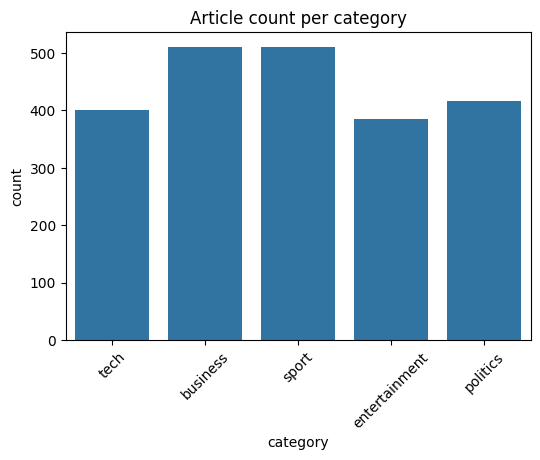

In [ ]:
# Rename columns if needed
if 'text' in df.columns:
    df = df.rename(columns={'text': 'content'})
if 'label' in df.columns:
    df = df.rename(columns={'label': 'category'})

# Drop missing values
df = df.dropna(subset=['content', 'category'])

# Display category distribution
print(df['category'].value_counts())

# Visualize distribution
plt.figure(figsize=(6,4))
sns.countplot(x='category', data=df)
plt.title('Article count per category')
plt.xticks(rotation=45)
plt.show()

In [61]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    clean_tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return ' '.join(clean_tokens)

# Apply preprocessing (this may take a few minutes)
df['clean_content'] = df['content'].apply(preprocess_text)

df[['content', 'clean_content']].head()

,content,clean_content
0,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


Accuracy: 0.9797752808988764
               precision    recall  f1-score   support

     business       0.98      0.97      0.98       102
entertainment       0.96      1.00      0.98        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.97      0.96      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



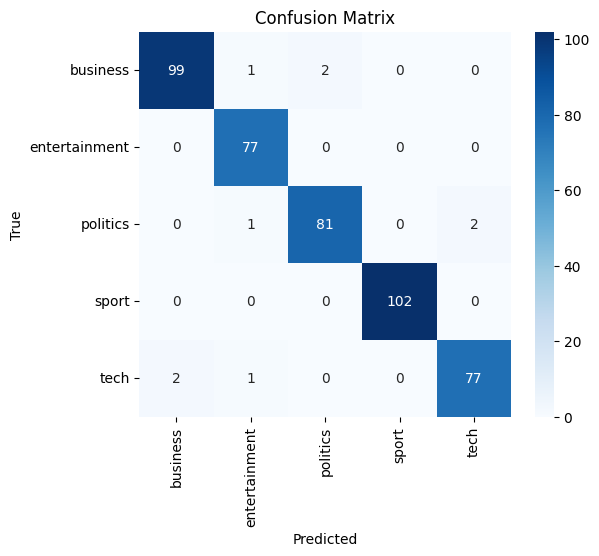

In [62]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [63]:
# Sample a subset for POS analysis (use a smaller sample to speed up)
pos_sample = df.sample(n=200, random_state=1)

# Function to get POS tag counts
def get_pos_counts(doc):
    doc_spacy = nlp(doc)
    pos_counts = {}
    for token in doc_spacy:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    return pos_counts

# Calculate POS counts per category
pos_distribution = {}
for category, group in pos_sample.groupby('category'):
    counts_list = group['content'].apply(get_pos_counts)
    # Sum counts across all documents in the category
    total_counts = {}
    for counts in counts_list:
        for tag, count in counts.items():
            total_counts[tag] = total_counts.get(tag, 0) + count
    pos_distribution[category] = total_counts

# Display POS distribution for each category
import pandas as pd
pos_df = pd.DataFrame(pos_distribution).fillna(0).astype(int)
pos_df

,business,entertainment,politics,sport,tech
NOUN,4431,2346,3383,3156,4640
VERB,2118,1090,1973,2116,2407
DET,1518,858,1459,1466,1570
ADJ,1398,705,1076,1103,1487
ADP,2146,1066,1612,1752,2060
PROPN,1461,1065,1244,1639,879
AUX,945,455,960,878,1121
PRON,695,519,939,1294,1012
SYM,128,13,25,109,46
NUM,702,250,260,518,432


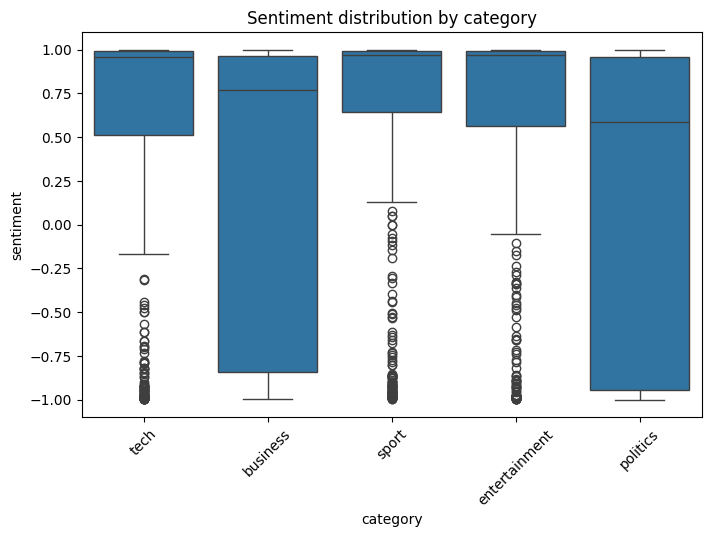

In [64]:
# Compute sentiment scores
df['sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot sentiment distribution by category
plt.figure(figsize=(8,5))
sns.boxplot(x='category', y='sentiment', data=df)
plt.title('Sentiment distribution by category')
plt.xticks(rotation=45)
plt.show()

In [65]:
# Sample a subset for NER (limit to 200 articles to control runtime)
ner_sample = df.sample(n=200, random_state=2)

# Function to extract selected entity types
def extract_entities(doc):
    doc_spacy = nlp(doc)
    entities = []
    for ent in doc_spacy.ents:
        if ent.label_ in {'PERSON', 'ORG', 'GPE', 'DATE', 'MONEY'}:
            entities.append((ent.text, ent.label_))
    return entities

# Build entity frequency dictionary
entity_freq = {}
for category, group in ner_sample.groupby('category'):
    entities_list = group['content'].apply(extract_entities)
    freq = {}
    for ents in entities_list:
        for text, label in ents:
            key = f"{label}: {text}"
            freq[key] = freq.get(key, 0) + 1
    entity_freq[category] = freq

# Convert to DataFrame and display top entities per category
entity_df = pd.DataFrame(entity_freq).fillna(0).astype(int)
# Show only top 10 entities for brevity
entity_df.head(10)

,business,entertainment,politics,sport,tech
DATE: annual,15,0,2,1,0
GPE: uk,5,7,18,0,15
MONEY: 775,1,0,0,0,0
DATE: 2008,2,0,0,0,1
MONEY: 1.5,1,0,0,0,0
GPE: us,49,15,9,7,19
MONEY: $1.5m,1,0,0,0,0
MONEY: £799 000,1,0,0,0,0
ORG: monsanto,4,0,0,0,0
DATE: two years ago,1,0,0,1,0


In [66]:
# Compute TF‑IDF matrix for all documents
full_tfidf = vectorizer.fit_transform(df['clean_content'])

# Map category labels to row indices
category_indices = {cat: df[df['category'] == cat].index for cat in df['category'].unique()}

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Compute top terms per category
top_terms = {}
for cat, indices in category_indices.items():
    # Sum TF‑IDF scores across rows in this category
    cat_tfidf_sum = full_tfidf[indices].sum(axis=0)
    cat_tfidf_array = cat_tfidf_sum.A1  # flatten
    # Get indices of top 10 terms
    top_idx = cat_tfidf_array.argsort()[-10:][::-1]
    top_terms[cat] = [(feature_names[i], cat_tfidf_array[i]) for i in top_idx]

# Display top terms
for cat, terms in top_terms.items():
    print(f"\nTop terms for {cat}:")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")


Top terms for tech:
  mobile: 19.7561
  game: 17.4501
  people: 17.4107
  phone: 17.1162
  technology: 16.6059
  said: 16.3917
  user: 14.8205
  computer: 13.9448
  software: 13.2295
  service: 13.1107

Top terms for business:
  bn: 27.3802
  said: 24.6624
  company: 19.6321
  firm: 18.3883
  bank: 18.3022
  market: 17.8154
  year: 17.5160
  growth: 17.2750
  economy: 16.9927
  share: 15.9796

Top terms for sport:
  game: 22.0964
  england: 18.1953
  player: 17.3869
  win: 17.1508
  match: 16.4403
  said: 15.8069
  cup: 14.7266
  team: 14.5350
  final: 14.1447
  champion: 13.9609

Top terms for entertainment:
  film: 39.4564
  award: 21.7736
  best: 17.9934
  show: 15.2195
  star: 15.0707
  music: 13.5702
  band: 12.8857
  said: 12.8786
  year: 12.6636
  oscar: 12.1514

Top terms for politics:
  mr: 36.5997
  said: 27.4557
  labour: 26.7856
  election: 25.0976
  party: 23.3875
  blair: 22.5217
  tory: 19.9178
  government: 19.1786
  would: 18.2632
  minister: 17.4172



Logistic Regression accuracy: 0.9798
               precision    recall  f1-score   support

     business       0.98      0.97      0.98       102
entertainment       0.96      1.00      0.98        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.97      0.96      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445


Multinomial NB accuracy: 0.9865
               precision    recall  f1-score   support

     business       0.99      0.96      0.98       102
entertainment       0.99      0.99      0.99        77
     politics       0.97      1.00      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.99      0.99      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99

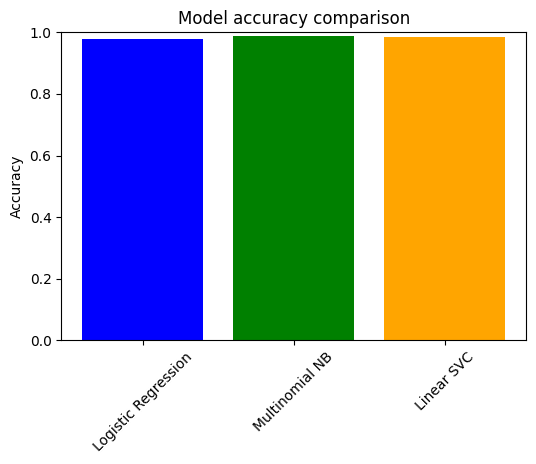

In [67]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'Linear SVC': LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"\n{name} accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

# Plot comparison
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['blue','green','orange'])
plt.ylim(0,1)
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [68]:
# Sample subset for syntax analysis
syntax_sample = df.sample(n=200, random_state=3)

# Function to count dependency labels in a text
def get_dependency_counts(doc):
    parsed = nlp(doc)
    counts = {}
    for token in parsed:
        dep = token.dep_
        counts[dep] = counts.get(dep, 0) + 1
    return counts

# Aggregate dependency counts per category
dep_distribution = {}
for cat, group in syntax_sample.groupby('category'):
    all_counts = {}
    for text in group['content']:
        dep_counts = get_dependency_counts(text)
        for dep, count in dep_counts.items():
            all_counts[dep] = all_counts.get(dep, 0) + count
    dep_distribution[cat] = all_counts

# Convert to DataFrame and view top dependencies
dep_df = pd.DataFrame(dep_distribution).fillna(0).astype(int)
# Show top 10 dependencies by total frequency
dep_df['total'] = dep_df.sum(axis=1)
dep_df_sorted = dep_df.sort_values('total', ascending=False)
dep_df_sorted.head(10)

,business,entertainment,politics,sport,tech,total
prep,1794,1092,2067,1559,2623,9135
pobj,1742,1081,1941,1413,2535,8712
det,1361,961,1941,1362,2220,7845
nsubj,1192,784,1984,1426,2150,7536
compound,1265,1043,1518,1259,1757,6842
punct,1026,713,1312,1239,1646,5936
dep,1024,764,1443,1053,1620,5904
amod,1161,679,1353,891,1766,5850
dobj,738,477,1181,866,1339,4601
aux,716,426,1260,775,1295,4472


In [69]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag, ne_chunk, word_tokenize

import spacy
nlp = spacy.load('en_core_web_sm')

# Ensure NLTK data is available. If running in Colab, download using nltk.download() as shown in the installation cell.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    clean_tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return ' '.join(clean_tokens)

# Apply preprocessing (this may take a few minutes)
df['clean_content'] = df['content'].apply(preprocess_text)

df[['content', 'clean_content']].head()

,content,clean_content
0,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


Accuracy: 0.9797752808988764
               precision    recall  f1-score   support

     business       0.98      0.97      0.98       102
entertainment       0.96      1.00      0.98        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.97      0.96      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



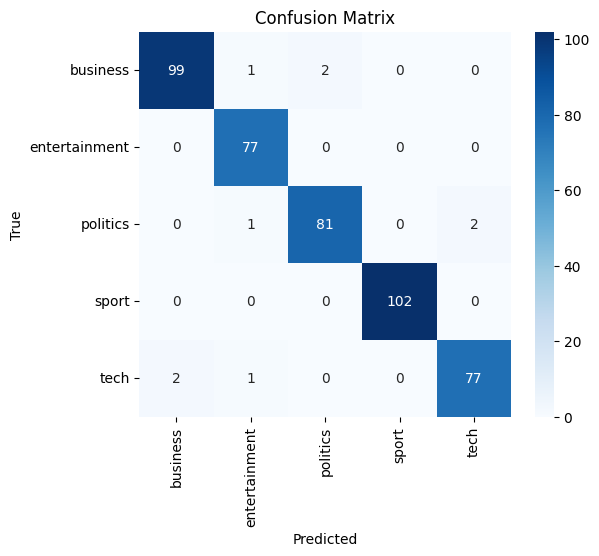

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

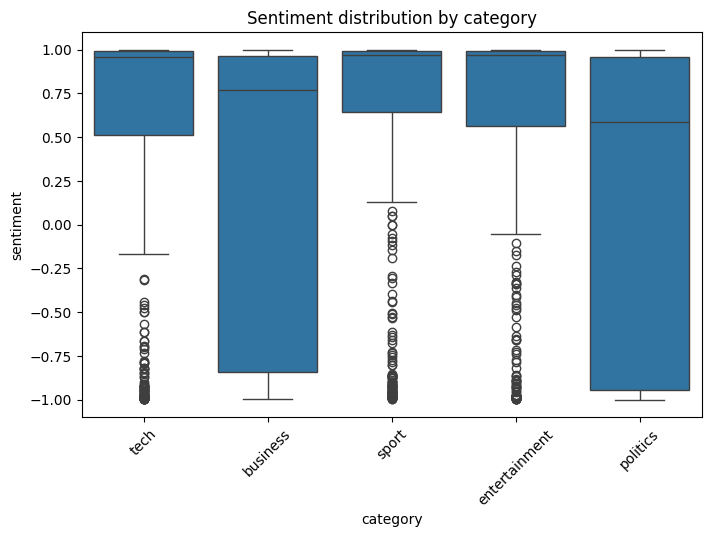

In [ ]:
# Compute sentiment scores
df['sentiment'] = df['content'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Plot sentiment distribution by category
plt.figure(figsize=(8,5))
sns.boxplot(x='category', y='sentiment', data=df)
plt.title('Sentiment distribution by category')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Compute TF‑IDF matrix for all documents
full_tfidf = vectorizer.fit_transform(df['clean_content'])

# Map category labels to row indices
category_indices = {cat: df[df['category'] == cat].index for cat in df['category'].unique()}

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Compute top terms per category
top_terms = {}
for cat, indices in category_indices.items():
    # Sum TF‑IDF scores across rows in this category
    cat_tfidf_sum = full_tfidf[indices].sum(axis=0)
    cat_tfidf_array = cat_tfidf_sum.A1  # flatten
    # Get indices of top 10 terms
    top_idx = cat_tfidf_array.argsort()[-10:][::-1]
    top_terms[cat] = [(feature_names[i], cat_tfidf_array[i]) for i in top_idx]

# Display top terms
for cat, terms in top_terms.items():
    print(f"\nTop terms for {cat}:")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")


Top terms for tech:
  mobile: 19.7561
  game: 17.4501
  people: 17.4107
  phone: 17.1162
  technology: 16.6059
  said: 16.3917
  user: 14.8205
  computer: 13.9448
  software: 13.2295
  service: 13.1107

Top terms for business:
  bn: 27.3802
  said: 24.6624
  company: 19.6321
  firm: 18.3883
  bank: 18.3022
  market: 17.8154
  year: 17.5160
  growth: 17.2750
  economy: 16.9927
  share: 15.9796

Top terms for sport:
  game: 22.0964
  england: 18.1953
  player: 17.3869
  win: 17.1508
  match: 16.4403
  said: 15.8069
  cup: 14.7266
  team: 14.5350
  final: 14.1447
  champion: 13.9609

Top terms for entertainment:
  film: 39.4564
  award: 21.7736
  best: 17.9934
  show: 15.2195
  star: 15.0707
  music: 13.5702
  band: 12.8857
  said: 12.8786
  year: 12.6636
  oscar: 12.1514

Top terms for politics:
  mr: 36.5997
  said: 27.4557
  labour: 26.7856
  election: 25.0976
  party: 23.3875
  blair: 22.5217
  tory: 19.9178
  government: 19.1786
  would: 18.2632
  minister: 17.4172



Logistic Regression accuracy: 0.9798
               precision    recall  f1-score   support

     business       0.98      0.97      0.98       102
entertainment       0.96      1.00      0.98        77
     politics       0.98      0.96      0.97        84
        sport       1.00      1.00      1.00       102
         tech       0.97      0.96      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445


Multinomial NB accuracy: 0.9865
               precision    recall  f1-score   support

     business       0.99      0.96      0.98       102
entertainment       0.99      0.99      0.99        77
     politics       0.97      1.00      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.99      0.99      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99

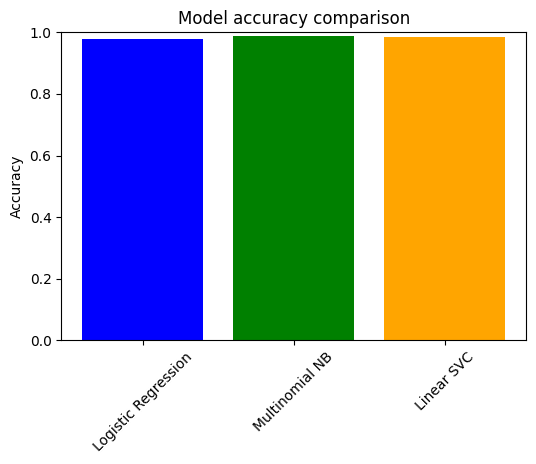

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'Linear SVC': LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"\n{name} accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

# Plot comparison
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['blue','green','orange'])
plt.ylim(0,1)
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [71]:
# Save the DataFrame to a CSV file
output_filename = 'bbc_news_dataset_output.csv'
df.to_csv(output_filename, index=False)

print(f"Dataset saved to {output_filename}")

Dataset saved to bbc_news_dataset_output.csv
